In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten

# 딥러닝 layer 관련
from tensorflow.keras.layers import Dense, Concatenate, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adamax

/Users/aiden/opt/anaconda3/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.10) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [33]:
# RMSE 함수 (keras에는 RMSE 메소드 없어서 만들어줘야 함)
def RMSE(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

In [39]:
# DataFrame 형태로 데이터를 읽어온다.
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']

# 평점 데이터 "u.data" 가져오기
ratings = pd.read_csv('./u.data', 
                     names=r_cols,
                      sep='\t',
                      encoding='latin-1'
                     )
print(ratings.shape)
ratings.head()

(100000, 4)


,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [40]:
# 학습, 테스트 구분하기
ratings_train, ratings_test = train_test_split(ratings, 
                                              test_size = 0.2, 
                                              shuffle = True, 
                                              random_state = 2021)

In [41]:
r_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']

# 유저 데이터 "u.user" 가져오기
users = pd.read_csv('./u.user', 
                     names=r_cols,
                      sep='|',
                      encoding='latin-1'
                     )
print(users.shape)
users.head()

(943, 5)


,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [42]:
# 사용자 ID(user_id)와 직업(occupation)만 남긴다.
users = users[['user_id', 'occupation']]
users.head()

,user_id,occupation
0,1,technician
1,2,other
2,3,writer
3,4,technician
4,5,other


In [43]:
# 직업 to index
occupation = {}
def convert_occ(x):
    if x in occupation:
        return occupation[x]
    else:
        occupation[x] = len(occupation)
        return occupation[x]
        
users['occupation'] = users['occupation'].apply(convert_occ)

In [44]:
users

,user_id,occupation
0,1,0
1,2,1
2,3,2
3,4,0
4,5,1
...,...,...
938,939,5
939,940,4
940,941,5
941,942,11


In [45]:
L = len(occupation)

train_occ = pd.merge(ratings_train, users, on='user_id')['occupation']
test_occ = pd.merge(ratings_test, users, on='user_id')['occupation']

In [46]:
# 잠재 요인의 수 
K = 200

# 전체 평점 평균
mu = ratings_train.rating.mean()

# 사용자id, 영화id의 최대값을 구한다.
# bias term의 크기 1을 고려하여 +1을 해준다.
M = ratings.user_id.max() + 1
N = ratings.movie_id.max() + 1

print('사용자 개수 max값:', M)
print('아이템 개수 max값:', N)

사용자 개수 max값: 944
아이템 개수 max값: 1683


# 케라스 모델 생성

In [47]:
user = Input(shape=(1, ))
item = Input(shape=(1, ))

# 행렬 P,Q 임베딩
P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item)

# 사용자, 아이템 평가 경향도 임베딩
user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user)
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item)

In [48]:
# concatenate를 위해서는 1차원으로 Flatten해야 한다.
P_embedding = Flatten()(P_embedding)
Q_embedding = Flatten()(Q_embedding)

user_bias = Flatten()(user_bias)
item_bias = Flatten()(item_bias)


In [49]:
occ = Input(shape=(1, ))
occ_embedding = Embedding(L, 3, embeddings_regularizer=l2())(occ)
occ_layer = Flatten()(occ_embedding)

R = Concatenate()([P_embedding, Q_embedding, user_bias, item_bias, occ_layer])

In [50]:
# layer 쌓기
# 활성화 함수는 'linear'
R = Dense(2048)(R)
R = Activation('linear')(R)

# 노드가 256개인 layer 추가
R = Dense(256)(R)
R = Activation('linear')(R)

# 노드가 1개인 dense layer(출력층) 한 개 추가
R = Dense(1)(R)

In [51]:
# input에 occ(직업) 데이터가 추가됨.
model = Model(inputs=[user, item, occ], outputs=R)

model.compile(
    loss = RMSE,
    optimizer = SGD(),  # adam, adamax
    metrics= [RMSE]
)

model.summary()
# 사용자 수가 944, 잠재요인 수가 200 -> 944x200 = 188800
# concatenate를 위해 flatten

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_7 (Embedding)        (None, 1, 200)       188800      ['input_6[0][0]']                
                                                                                            

In [52]:
# 학습 데이터 정의
train_user_ids = ratings_train.user_id.values, 
train_movie_ids = ratings_train.movie_id.values
train_ratings = ratings_train.rating.values
train_occs = train_occ.values   # occ(직업) 데이터 추가

# 테스트 데이터 정의
test_user_ids = ratings_test.user_id.values, 
test_movie_ids = ratings_test.movie_id.values
test_ratings = ratings_test.rating.values
test_occs = test_occ.values   # occ(직업) 데이터 추가

In [54]:
%%time
# 학습시간 약 5분
result = model.fit(
    x = [train_user_ids, train_movie_ids, train_occs], 
    y = train_ratings - mu,
    epochs = 65,
    batch_size = 512,
    validation_data = (
        [test_user_ids, test_movie_ids, test_occs],
        test_ratings - mu
    )
)

Epoch 1/65
157/157 [==============================] - 4s 24ms/step - loss: 5.0327 - RMSE: 1.1227 - val_loss: 4.9007 - val_RMSE: 1.1139
Epoch 2/65
157/157 [==============================] - 4s 25ms/step - loss: 4.7931 - RMSE: 1.1212 - val_loss: 4.6688 - val_RMSE: 1.1123
Epoch 3/65
157/157 [==============================] - 4s 27ms/step - loss: 4.5681 - RMSE: 1.1196 - val_loss: 4.4508 - val_RMSE: 1.1106
Epoch 4/65
157/157 [==============================] - 5s 29ms/step - loss: 4.3567 - RMSE: 1.1181 - val_loss: 4.2459 - val_RMSE: 1.1087
Epoch 5/65
157/157 [==============================] - 5s 29ms/step - loss: 4.1579 - RMSE: 1.1161 - val_loss: 4.0533 - val_RMSE: 1.1068
Epoch 6/65
157/157 [==============================] - 5s 29ms/step - loss: 3.9708 - RMSE: 1.1141 - val_loss: 3.8722 - val_RMSE: 1.1046
Epoch 7/65
157/157 [==============================] - 4s 26ms/step - loss: 3.7948 - RMSE: 1.1112 - val_loss: 3.7018 - val_RMSE: 1.1022
Epoch 8/65
157/157 [==============================] - 5

157/157 [==============================] - 6s 41ms/step - loss: 1.0286 - RMSE: 0.9225 - val_loss: 1.0326 - val_RMSE: 0.9281
Epoch 62/65
157/157 [==============================] - 6s 40ms/step - loss: 1.0230 - RMSE: 0.9227 - val_loss: 1.0334 - val_RMSE: 0.9343
Epoch 63/65
157/157 [==============================] - 6s 39ms/step - loss: 1.0176 - RMSE: 0.9231 - val_loss: 1.0271 - val_RMSE: 0.9332
Epoch 64/65
157/157 [==============================] - 6s 40ms/step - loss: 1.0127 - RMSE: 0.9230 - val_loss: 1.0176 - val_RMSE: 0.9287
Epoch 65/65
157/157 [==============================] - 7s 44ms/step - loss: 1.0076 - RMSE: 0.9219 - val_loss: 1.0126 - val_RMSE: 0.9283
CPU times: user 25min 25s, sys: 6min 10s, total: 31min 36s
Wall time: 5min 35s


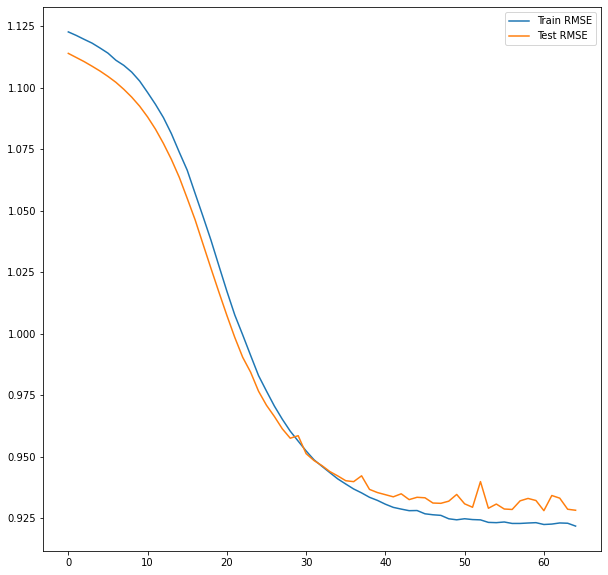

In [55]:
# 학습 과정 시각화
plt.figure(figsize=(10, 10))
plt.plot(result.history['RMSE'], label="Train RMSE")
plt.plot(result.history['val_RMSE'], label="Test RMSE")
plt.legend()
plt.show()

In [58]:
# 모델로 test 데이터 예측
predictions = model.predict([test_user_ids, test_movie_ids, test_occs]) + mu

# 예측값들 확인
predictions[:15]

array([[3.6896703],
       [2.9029665],
       [4.4054694],
       [3.5703783],
       [1.5099602],
       [4.406602 ],
       [3.590345 ],
       [3.2042623],
       [5.0697284],
       [4.0335493],
       [3.5604706],
       [2.2098293],
       [4.3957357],
       [3.974768 ],
       [4.1710577]], dtype=float32)

In [60]:
# 실제값
print(ratings_test.rating[:15])

23307    3
36679    3
36626    5
83753    2
52604    1
49877    5
83837    3
46797    2
31308    5
5448     4
70587    5
70425    2
55063    5
67450    4
86251    4
Name: rating, dtype: int64


In [61]:
import numpy as np

# 넘파이를 활용한 RMSE 함수
def RMSE2(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

In [62]:
# ravel : 1차원으로 변환
y_pred = np.ravel(predictions, order='C')
y_true = np.array(ratings_test.rating)

RMSE2(y_true, y_pred)

0.9301820892735928